In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import pandas as pd
import functools


from scipy.optimize import differential_evolution as diff_evol

class SpecialDict(dict):
    
    def values(self):
        return list(super().values())
    
% run functions.ipynb

matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

## Fed batch model 

In [2]:
# Load experimental data
R23_amounts = pd.read_csv('estimation/fedbatch_amounts/R23_amounts.csv', index_col=0)
R24_amounts = pd.read_csv('estimation/fedbatch_amounts/R24_amounts.csv', index_col=0)
R23_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R23.csv')
R24_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R24.csv')
R23_CO2_selected, mu_R23 = calculate_mu_fedbatch(R23_CO2, 23)
R24_CO2_selected, mu_R24 = calculate_mu_fedbatch(R24_CO2, 24)

In [7]:
fedbatch_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02 #0.16 #0.02 #0.16 #0.15
    alpha = 1.5007
    beta = 2.7714

    
    ######## Initial conditions
    V = 0.1021 # [L]
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V # [g/L]


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta) # [g_product/g_biomass h]
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    
    qpbio := qp*biomass
    glucosetiter := glucose/V
    

    end
'''

r = te.loada(fedbatch_model)
r.resetToOrigin()
#r.Ki = 5
#r.mu_set = 0.064 
#r.mu_set = 0.1112
#print(r.getCurrentAntimony())

    
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V', 'qp','qpbio','glucosetiter']
results = r.simulate(12.5, 33, 67)
results

       time,   glucose,  biomass,     serine,        mu,         Fin,        V,        qp,      qpbio, glucosetiter
 [[    12.5,         0, 0.209504,          0,         0, 0.000385208,   0.1021,         0,          0,            0],
  [ 12.8106, 0.0429669, 0.211583, 0.00110966,  0.056136, 0.000387608,  0.10222, 0.0297939, 0.00630387,     0.420337],
  [ 13.1212, 0.0762811,  0.21635, 0.00362531, 0.0847003, 0.000390023, 0.102341, 0.0445046, 0.00962859,     0.745364],
  [ 13.4318,  0.103007, 0.222762, 0.00698274,  0.102068, 0.000392454, 0.102462, 0.0533059,  0.0118745,      1.00531],
  [ 13.7424,  0.124674, 0.230376,  0.0109505,   0.11361, 0.000394899, 0.102585, 0.0590968,  0.0136145,      1.21533],
  [  14.053,  0.142173, 0.238965,  0.0154121,  0.121646,  0.00039736, 0.102708, 0.0631011,   0.015079,      1.38425],
  [ 14.3636,  0.156081,   0.2484,  0.0203007,   0.12735, 0.000399836, 0.102831, 0.0659298,   0.016377,      1.51783],
  [ 14.6742,  0.166809, 0.258594,  0.0255744,  0.131383, 0

In [8]:
# With mu_set = 0.0112
serine_titer_011 = 4.52202/0.197122
print(serine_titer_011)

serine_production_rate_011 = 0.621697

# With original mu_set = 0.02
serine_titer_002 = 0.578248/0.111862
print(serine_titer_002)

serine_production_rate_002 = 0.0379849

22.940209616379708
5.169297884893886


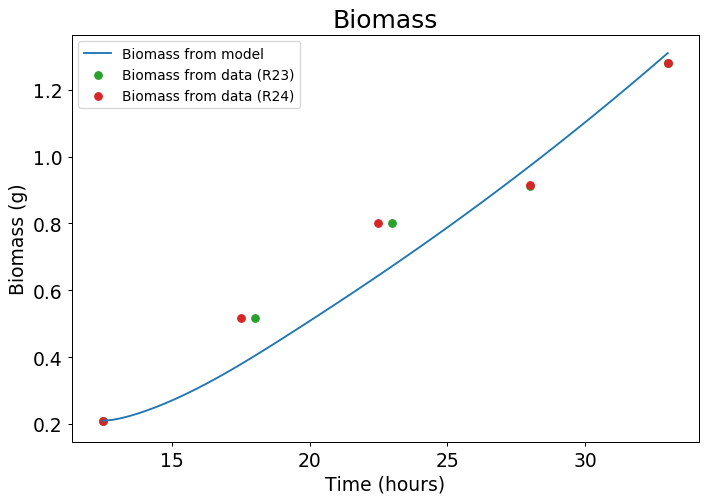

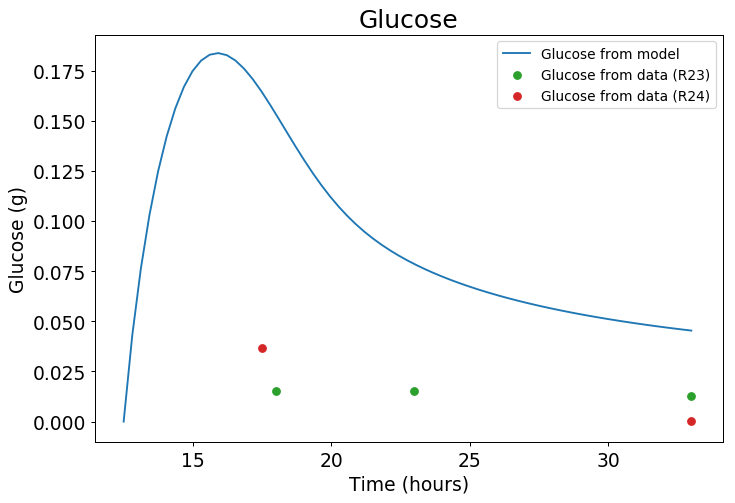

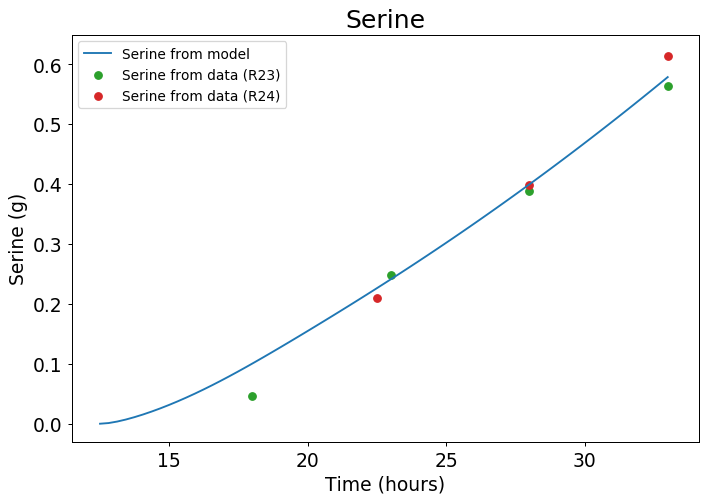

In [9]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Biomass (g)', fontsize = 15)
plt.title('Biomass', fontsize = 20)

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)


plt.show()


plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)


plt.show()

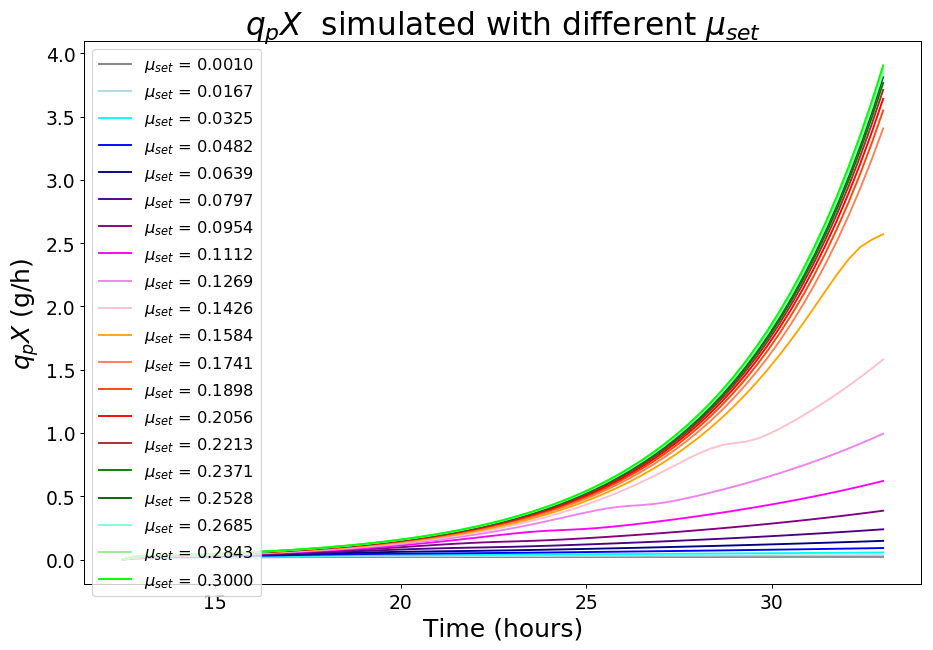

In [41]:
#'qpX simulated with different mu_set values

matplotlib.rcParams.update({'font.size': 11})


r.resetToOrigin()
#print(r.getCurrentAntimony())

# Simulate the model for qpbio and time with normal settings
m = r.simulate(12.5, 33, 67, ['time','qpbio']) 

# Make a linearly spaced list with the mu_set values
par = np.linspace(0.001, 0.3, num=20)

# Estimation has to be a list with uneven numbers, so the result can be plotted in the loop
estimations = np.linspace(1, 39, num=20)

colors = ['grey', 'lightblue', 'aqua', 'blue', 'navy', 'indigo', 'purple', 'magenta', 'violet', 'pink', 'orange', 'coral', 'orangered', 'red', 'brown', 'green', 'darkgreen', 'aquamarine', 'lightgreen','lime']

# Simulates the model and plot for the different mu_set par values. 
plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i, j, cols in zip(estimations.astype(int), par, colors):
    
    r.resetToOrigin()
    r.mu_set = j
        
    m = np.hstack([m, r.simulate(12.5, 33, 67, ['time','qpbio'])])
    hej = pd.DataFrame(m)
    hej.drop([0,1], axis=1, inplace=True)
    
    plt.plot(hej.iloc[:,i-1],hej.iloc[:,i], label = r'$\mu_{set}$' ' = ' + "{:.4f}".format(r.mu_set), color=cols)
        
plt.xlabel('Time (hours)', fontsize = 20)
plt.ylabel(r'$q_pX$ (g/h)', fontsize = 20)
plt.title(r'$q_pX$ '+ ' simulated with different ' + r'$\mu_{set}$', fontsize = 25)
plt.legend(fontsize = 13, loc = 'upper left')
plt.savefig('figures/feed/qp_muset_normalpar.pdf')
plt.show()   

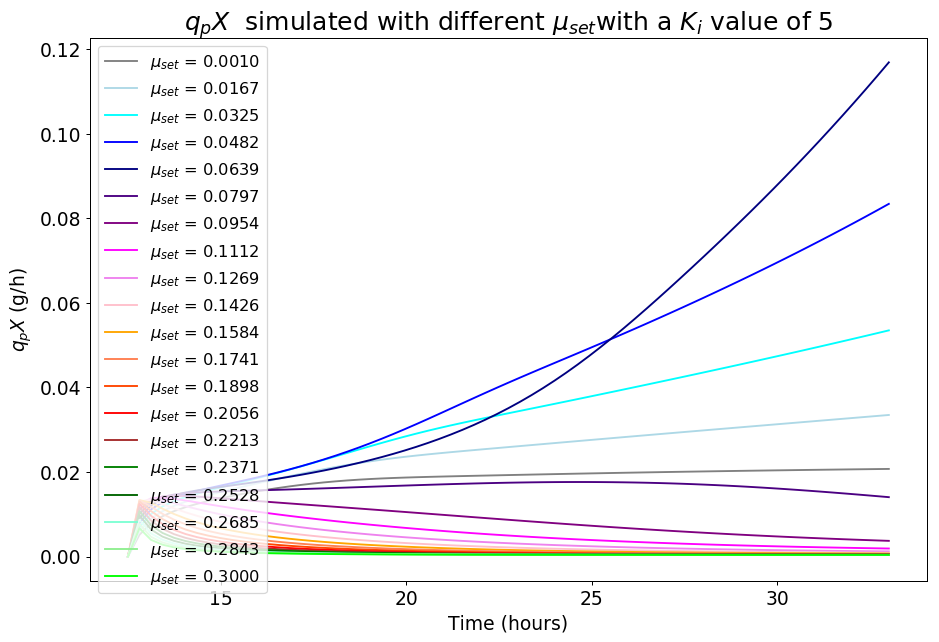

In [40]:
#'qpX simulated with different r$'\alpha'

matplotlib.rcParams.update({'font.size': 11})
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
from random import shuffle


r.resetToOrigin()
r.Ki = 5
#print(r.getCurrentAntimony())

# Simulate the model for qpbio and time with Ki = 5
m = r.simulate(12.5, 33, 67, ['time','qpbio']) 


# Make a linearly spaced list with the mu_set values
par = np.linspace(0.001, 0.3, num=20)

# Estimation has to be a list with uneven numbers, so the result can be plotted in the loop
estimations = np.linspace(1, 39, num=20)

colors = ['grey', 'lightblue', 'aqua', 'blue', 'navy', 'indigo', 'purple', 'magenta', 'violet', 'pink', 'orange', 'coral', 'orangered', 'red', 'brown', 'green', 'darkgreen', 'aquamarine', 'lightgreen','lime']

plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i, j, cols in zip(estimations.astype(int), par, colors):
    
    r.reset()
    r.Ki = 5
    r.mu_set = j
        
    m = np.hstack([m, r.simulate(12.5, 33, 67, ['time','qpbio'])])
    hej = pd.DataFrame(m)
    
    hej.drop([0,1], axis=1, inplace=True)
    
    plt.plot(hej.iloc[:,i -1],hej.iloc[:,i], label = r'$\mu_{set}$' ' = ' + "{:.4f}".format(r.mu_set), color=cols)
        
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel(r'$q_pX$ (g/h)', fontsize = 15)
plt.title(r'$q_pX$ '+ ' simulated with different ' + r'$\mu_{set}$' + 'with a ' + r'$K_{i}$ value of 5', fontsize = 20)
plt.legend(loc='upper left', fontsize = 13)
plt.savefig('figures/feed/qp_muset_lowKi.png')
plt.show()   

## Fed batch model constant feed 

In [2]:
R23_amounts = pd.read_csv('estimation/fedbatch_amounts/R23_amounts.csv', index_col=0)
R24_amounts = pd.read_csv('estimation/fedbatch_amounts/R24_amounts.csv', index_col=0)
R23_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R23.csv')
R24_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R24.csv')
R23_CO2_selected, mu_R23 = calculate_mu_fedbatch(R23_CO2, 23)
R24_CO2_selected, mu_R24 = calculate_mu_fedbatch(R24_CO2, 24)

In [75]:
fedbatch_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    alpha = 1.5007
    beta = 2.7714
    X0 = 0.284386
    thing_to_optimize = 0.12

    
    
    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    
    qpbio := qp*biomass
    

    end
'''

r = te.loada(fedbatch_model)
r.resetToOrigin()
#r.Ki = 5
#r.mu_set = 0.064 
#r.mu_set = 0.16
#print(r.getCurrentAntimony())

    
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V', 'qp','qpbio']
results = r.simulate(12.5, 33, 67)

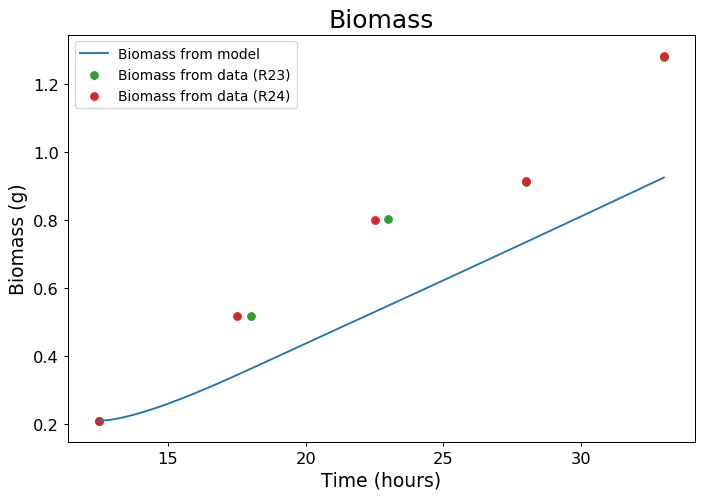

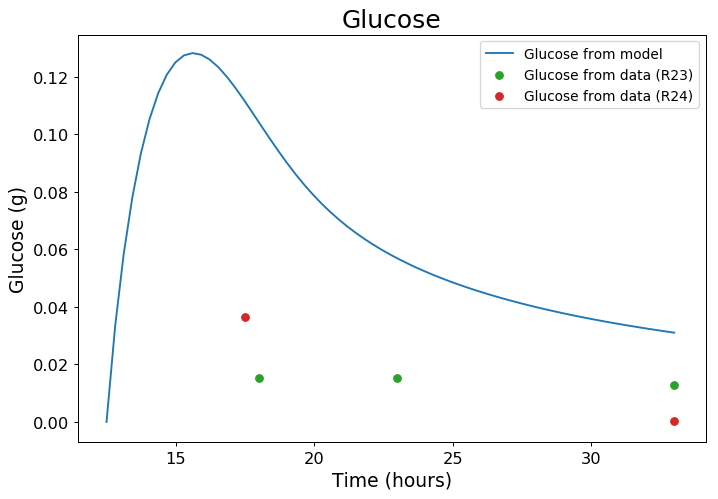

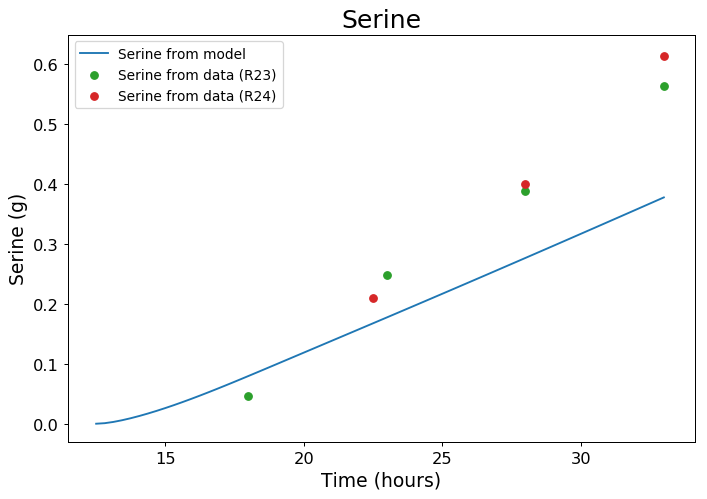

In [49]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Biomass (g)', fontsize = 15)
plt.title('Biomass', fontsize = 20)

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)


plt.show()


plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)


plt.show()

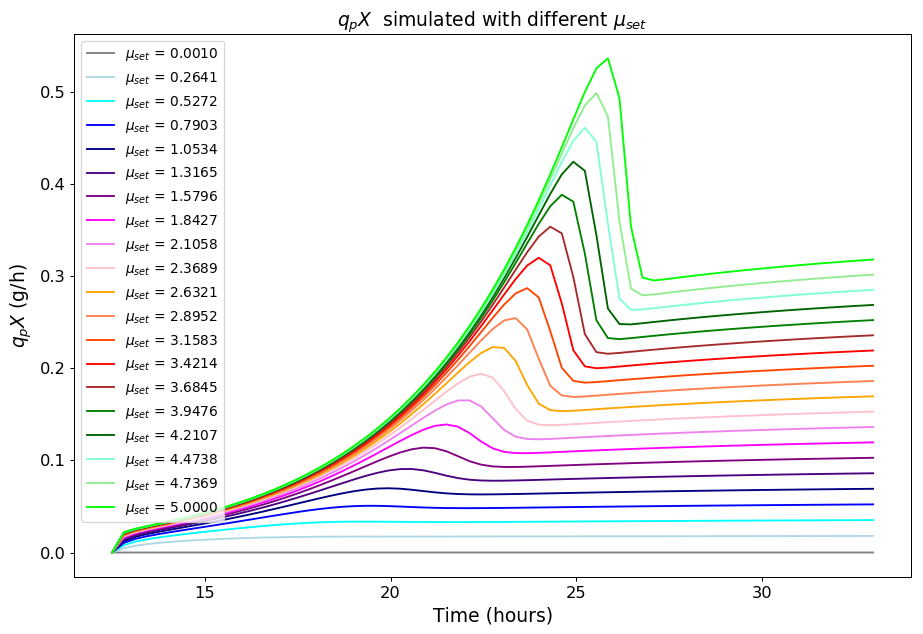

In [54]:
#'qpX simulated with different r$'\alpha'

matplotlib.rcParams.update({'font.size': 11})
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
from random import shuffle


r.resetToOrigin()
#print(r.getCurrentAntimony())

# Simulate the model for qpbio and time with normal settings
m = r.simulate(12.5, 33, 67, ['time','qpbio']) 

# Make a linearly spaced list with the mu_set values
par = np.linspace(0.001, 5, num=20)

# Estimation has to be a list with uneven numbers, so the result can be plotted in the loop
estimations = np.linspace(1, 39, num=20)

colors = ['grey', 'lightblue', 'aqua', 'blue', 'navy', 'indigo', 'purple', 'magenta', 'violet', 'pink', 'orange', 'coral', 'orangered', 'red', 'brown', 'green', 'darkgreen', 'aquamarine', 'lightgreen','lime']

plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i, j, cols in zip(estimations.astype(int), par, colors):
    
    r.resetToOrigin()
    r.F0 = j
        
    m = np.hstack([m, r.simulate(12.5, 33, 67, ['time','qpbio'])])
    hej = pd.DataFrame(m)
    hej.drop([0,1], axis=1, inplace=True)
    
    plt.plot(hej.iloc[:,i-1],hej.iloc[:,i], label = r'$\mu_{set}$' ' = ' + "{:.4f}".format(r.F0), color=cols)
        
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel(r'$q_pX$ (g/h)', fontsize = 15)
plt.title(r'$q_pX$ '+ ' simulated with different ' + r'$\mu_{set}$', fontsize = 15)
plt.legend()
plt.savefig('figures/feed/qp_muset_normalpar.png')
plt.show()   

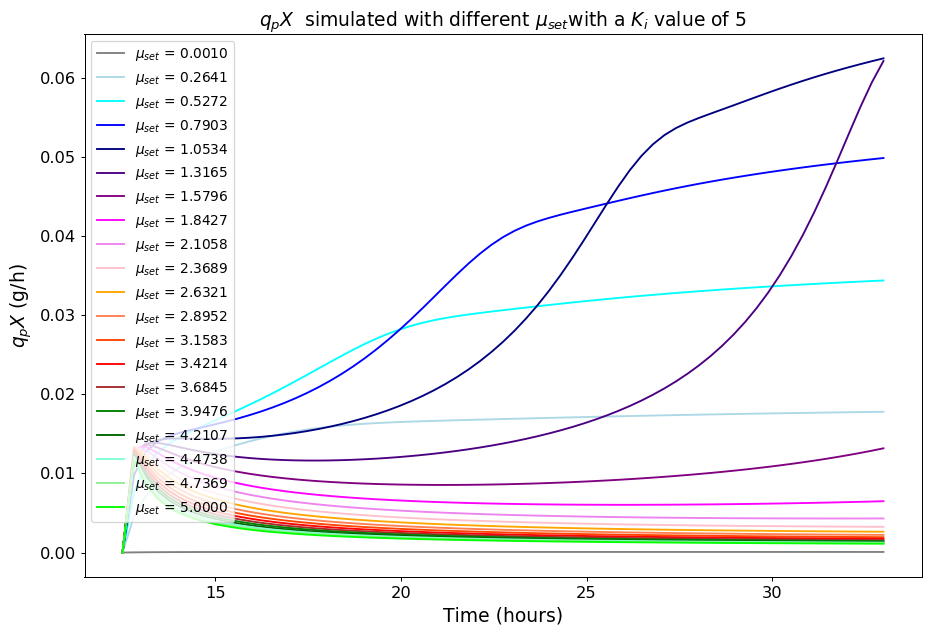

In [55]:
#'qpX simulated with different r$'\alpha'

matplotlib.rcParams.update({'font.size': 11})
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
from random import shuffle


r.resetToOrigin()
r.Ki = 5
#print(r.getCurrentAntimony())

# Simulate the model for qpbio and time with Ki = 5
m = r.simulate(12.5, 33, 67, ['time','qpbio']) 

# Make a linearly spaced list with the mu_set values
par = np.linspace(0.001, 5, num=20)

# Estimation has to be a list with uneven numbers, so the result can be plotted in the loop
estimations = np.linspace(1, 39, num=20)

colors = ['grey', 'lightblue', 'aqua', 'blue', 'navy', 'indigo', 'purple', 'magenta', 'violet', 'pink', 'orange', 'coral', 'orangered', 'red', 'brown', 'green', 'darkgreen', 'aquamarine', 'lightgreen','lime']

plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i, j, cols in zip(estimations.astype(int), par, colors):
    
    r.reset()
    r.Ki = 5
    r.F0 = j
        
    m = np.hstack([m, r.simulate(12.5, 33, 67, ['time','qpbio'])])
    hej = pd.DataFrame(m)
    
    hej.drop([0,1], axis=1, inplace=True)
    
    plt.plot(hej.iloc[:,i -1],hej.iloc[:,i], label = r'$\mu_{set}$' ' = ' + "{:.4f}".format(r.F0), color=cols)
        
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel(r'$q_pX$ (g/h)', fontsize = 15)
plt.title(r'$q_pX$ '+ ' simulated with different ' + r'$\mu_{set}$' + 'with a ' + r'$K_{i}$ value of 5', fontsize = 15)
plt.legend(loc='upper left')
plt.savefig('figures/feed/qp_muset_lowKi.png')
plt.show()   